# RoboReviews
### The new product review aggregator
This project focuses on developing a product review website powered by Natural Language Processing (NLP) models. The platform aggregates and analyzes customer feedback from multiple sources to provide actionable insights and enhance decision-making for product improvements.

Key Features and Objectives:
	1.	Sentiment Analysis: Classify customer reviews into positive, negative, or neutral categories to help companies understand customer sentiment and improve products and services.
	2.	Product Clustering: Group product categories into just 4-6 clusters for better organization and user navigation.
	3.	Generative AI Summaries: Use Large Language Models (LLMs) to summarize reviews and generate articles recommending the top products in each category. Classical summarization techniques are intentionally avoided for this task to leverage the power of state-of-the-art LLMs.

    Dataset:

The original dataset used for this project is publicly available on Kaggle:
Consumer Reviews of Amazon Products


### 1. Setup & Initialisation

In [1]:
!pip install sentence-transformers
!pip install wordcloud
import pandas as pd
import numpy as np
import re
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
import nltk
nltk.download('stopwords')
nltk.download('punkt')
from sklearn.feature_extraction.text import TfidfVectorizer
from nltk.sentiment import SentimentIntensityAnalyzer
from collections import Counter
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.metrics import classification_report
from wordcloud import WordCloud
from sentence_transformers import SentenceTransformer
from sklearn.cluster import KMeans
from sklearn.metrics.pairwise import cosine_similarity
import numpy as np

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity

[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/paulmuller/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     /Users/paulmuller/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


### Step 2: Load the Dataset


In [2]:
file_path = './data/1429_1.csv'  # loading file from directory 
data = pd.read_csv(file_path)

/var/folders/7n/00k0v2dx0svg_h5qbblr0y3w0000gn/T/ipykernel_12064/1794808198.py:2: DtypeWarning: Columns (1,10) have mixed types. Specify dtype option on import or set low_memory=False.
  data = pd.read_csv(file_path)


In [3]:
# Display the first few rows
print("Dataset Preview:")
data.head()

Dataset Preview:


,id,name,asins,brand,categories,keys,manufacturer,reviews.date,reviews.dateAdded,reviews.dateSeen,...,reviews.doRecommend,reviews.id,reviews.numHelpful,reviews.rating,reviews.sourceURLs,reviews.text,reviews.title,reviews.userCity,reviews.userProvince,reviews.username
0,AVqkIhwDv8e3D1O-lebb,"All-New Fire HD 8 Tablet, 8 HD Display, Wi-Fi,...",B01AHB9CN2,Amazon,"Electronics,iPad & Tablets,All Tablets,Fire Ta...","841667104676,amazon/53004484,amazon/b01ahb9cn2...",Amazon,2017-01-13T00:00:00.000Z,2017-07-03T23:33:15Z,"2017-06-07T09:04:00.000Z,2017-04-30T00:45:00.000Z",...,True,NaN,0.0,5.0,http://reviews.bestbuy.com/3545/5620406/review...,This product so far has not disappointed. My c...,Kindle,NaN,NaN,Adapter
1,AVqkIhwDv8e3D1O-lebb,"All-New Fire HD 8 Tablet, 8 HD Display, Wi-Fi,...",B01AHB9CN2,Amazon,"Electronics,iPad & Tablets,All Tablets,Fire Ta...","841667104676,amazon/53004484,amazon/b01ahb9cn2...",Amazon,2017-01-13T00:00:00.000Z,2017-07-03T23:33:15Z,"2017-06-07T09:04:00.000Z,2017-04-30T00:45:00.000Z",...,True,NaN,0.0,5.0,http://reviews.bestbuy.com/3545/5620406/review...,great for beginner or experienced person. Boug...,very fast,NaN,NaN,truman
2,AVqkIhwDv8e3D1O-lebb,"All-New Fire HD 8 Tablet, 8 HD Display, Wi-Fi,...",B01AHB9CN2,Amazon,"Electronics,iPad & Tablets,All Tablets,Fire Ta...","841667104676,amazon/53004484,amazon/b01ahb9cn2...",Amazon,2017-01-13T00:00:00.000Z,2017-07-03T23:33:15Z,"2017-06-07T09:04:00.000Z,2017-04-30T00:45:00.000Z",...,True,NaN,0.0,5.0,http://reviews.bestbuy.com/3545/5620406/review...,Inexpensive tablet for him to use and learn on...,Beginner tablet for our 9 year old son.,NaN,NaN,DaveZ
3,AVqkIhwDv8e3D1O-lebb,"All-New Fire HD 8 Tablet, 8 HD Display, Wi-Fi,...",B01AHB9CN2,Amazon,"Electronics,iPad & Tablets,All Tablets,Fire Ta...","841667104676,amazon/53004484,amazon/b01ahb9cn2...",Amazon,2017-01-13T00:00:00.000Z,2017-07-03T23:33:15Z,"2017-06-07T09:04:00.000Z,2017-04-30T00:45:00.000Z",...,True,NaN,0.0,4.0,http://reviews.bestbuy.com/3545/5620406/review...,I've had my Fire HD 8 two weeks now and I love...,Good!!!,NaN,NaN,Shacks
4,AVqkIhwDv8e3D1O-lebb,"All-New Fire HD 8 Tablet, 8 HD Display, Wi-Fi,...",B01AHB9CN2,Amazon,"Electronics,iPad & Tablets,All Tablets,Fire Ta...","841667104676,amazon/53004484,amazon/b01ahb9cn2...",Amazon,2017-01-12T00:00:00.000Z,2017-07-03T23:33:15Z,"2017-06-07T09:04:00.000Z,2017-04-30T00:45:00.000Z",...,True,NaN,0.0,5.0,http://reviews.bestbuy.com/3545/5620406/review...,I bought this for my grand daughter when she c...,Fantastic Tablet for kids,NaN,NaN,explore42


In [4]:
# checking datatypes of columns
data.dtypes

id                       object
name                     object
asins                    object
brand                    object
categories               object
keys                     object
manufacturer             object
reviews.date             object
reviews.dateAdded        object
reviews.dateSeen         object
reviews.didPurchase      object
reviews.doRecommend      object
reviews.id              float64
reviews.numHelpful      float64
reviews.rating          float64
reviews.sourceURLs       object
reviews.text             object
reviews.title            object
reviews.userCity        float64
reviews.userProvince    float64
reviews.username         object
dtype: object

In [5]:
# seeing more structure and insights about the dataset
data.describe

<bound method NDFrame.describe of                          id  \
0      AVqkIhwDv8e3D1O-lebb   
1      AVqkIhwDv8e3D1O-lebb   
2      AVqkIhwDv8e3D1O-lebb   
3      AVqkIhwDv8e3D1O-lebb   
4      AVqkIhwDv8e3D1O-lebb   
...                     ...   
34655  AVpfiBlyLJeJML43-4Tp   
34656  AVpfiBlyLJeJML43-4Tp   
34657  AVpfiBlyLJeJML43-4Tp   
34658  AVpfiBlyLJeJML43-4Tp   
34659  AVpfiBlyLJeJML43-4Tp   

                                                    name       asins   brand  \
0      All-New Fire HD 8 Tablet, 8 HD Display, Wi-Fi,...  B01AHB9CN2  Amazon   
1      All-New Fire HD 8 Tablet, 8 HD Display, Wi-Fi,...  B01AHB9CN2  Amazon   
2      All-New Fire HD 8 Tablet, 8 HD Display, Wi-Fi,...  B01AHB9CN2  Amazon   
3      All-New Fire HD 8 Tablet, 8 HD Display, Wi-Fi,...  B01AHB9CN2  Amazon   
4      All-New Fire HD 8 Tablet, 8 HD Display, Wi-Fi,...  B01AHB9CN2  Amazon   
...                                                  ...         ...     ...   
34655                            

### Step 3: Data-Preprocessing

In [6]:
# Check for missing values
print("\nMissing Values:")
print(data.isnull().sum())


Missing Values:
id                          0
name                     6760
asins                       2
brand                       0
categories                  0
keys                        0
manufacturer                0
reviews.date               39
reviews.dateAdded       10621
reviews.dateSeen            0
reviews.didPurchase     34659
reviews.doRecommend       594
reviews.id              34659
reviews.numHelpful        529
reviews.rating             33
reviews.sourceURLs          0
reviews.text                1
reviews.title               6
reviews.userCity        34660
reviews.userProvince    34660
reviews.username            7
dtype: int64


In [7]:

# Count occurrences of the exact string before replacement
change_count = data['name'].str.count(
    r"Fire Tablet, 7 Display, Wi-Fi, 8 GB - Includes Special Offers, Tangerine\""
).sum()

# Replace the specific string
data['name'] = data['name'].str.replace(
    r"Fire Tablet, 7 Display, Wi-Fi, 8 GB - Includes Special Offers, Tangerine\"",
    "Echo (White),,,",
    regex=True
)

# Print the number of changes made
print(f"Number of corrections made: {int(change_count)}")

Number of corrections made: 1


In [8]:
# Filter and display rows where the 'name' column is null
null_entries = data[data['name'].isnull()]

# Display the rows with null values in the 'name' column
print(null_entries)

# Count how many rows have null values in the 'name' column
print(f"Number of rows with 'name' as null: {null_entries.shape[0]}")

                         id name                  asins   brand  \
27900  AVpfl8cLLJeJML43AE3S  NaN  B00L9EPT8O,B01E6AO69U  Amazon   
27901  AVpfl8cLLJeJML43AE3S  NaN  B00L9EPT8O,B01E6AO69U  Amazon   
27902  AVpfl8cLLJeJML43AE3S  NaN  B00L9EPT8O,B01E6AO69U  Amazon   
27903  AVpfl8cLLJeJML43AE3S  NaN  B00L9EPT8O,B01E6AO69U  Amazon   
27904  AVpfl8cLLJeJML43AE3S  NaN  B00L9EPT8O,B01E6AO69U  Amazon   
...                     ...  ...                    ...     ...   
34655  AVpfiBlyLJeJML43-4Tp  NaN             B006GWO5WK  Amazon   
34656  AVpfiBlyLJeJML43-4Tp  NaN             B006GWO5WK  Amazon   
34657  AVpfiBlyLJeJML43-4Tp  NaN             B006GWO5WK  Amazon   
34658  AVpfiBlyLJeJML43-4Tp  NaN             B006GWO5WK  Amazon   
34659  AVpfiBlyLJeJML43-4Tp  NaN             B006GWO5WK  Amazon   

                                              categories  \
27900  Stereos,Remote Controls,Amazon Echo,Audio Dock...   
27901  Stereos,Remote Controls,Amazon Echo,Audio Dock...   
27902  Stereos,

In [9]:
# # for visual inspection, checking the file of none named entries of the dataset 
# null_entries.to_csv('null_name_entries.csv', index=False)
# print("Rows with null 'name' saved to 'null_name_entries.csv'")

In [10]:
# # Fill NaN values with a placeholder
# data['name'] = data['name'].fillna("unknown")

In [11]:
# Drop rows with missing name
data = data.dropna(subset=['name'])
print(f"\nDataset after dropping missing values: {data.shape}")


Dataset after dropping missing values: (27900, 21)


In [12]:
# Drop rows with missing reviews
data = data.dropna(subset=['reviews.text'])
print(f"\nDataset after dropping missing values: {data.shape}")


Dataset after dropping missing values: (27899, 21)


In [13]:
# Drop rows with missing reviews.ratings
data = data.dropna(subset=['reviews.rating'])
print(f"\nDataset after dropping missing values: {data.shape}")


Dataset after dropping missing values: (27867, 21)


In [14]:
# Drop rows with missing reviews.titels
data = data.dropna(subset=['reviews.title'])
print(f"\nDataset after dropping missing values: {data.shape}")


Dataset after dropping missing values: (27863, 21)


In [15]:
data.head(15000)

,id,name,asins,brand,categories,keys,manufacturer,reviews.date,reviews.dateAdded,reviews.dateSeen,...,reviews.doRecommend,reviews.id,reviews.numHelpful,reviews.rating,reviews.sourceURLs,reviews.text,reviews.title,reviews.userCity,reviews.userProvince,reviews.username
0,AVqkIhwDv8e3D1O-lebb,"All-New Fire HD 8 Tablet, 8 HD Display, Wi-Fi,...",B01AHB9CN2,Amazon,"Electronics,iPad & Tablets,All Tablets,Fire Ta...","841667104676,amazon/53004484,amazon/b01ahb9cn2...",Amazon,2017-01-13T00:00:00.000Z,2017-07-03T23:33:15Z,"2017-06-07T09:04:00.000Z,2017-04-30T00:45:00.000Z",...,True,NaN,0.0,5.0,http://reviews.bestbuy.com/3545/5620406/review...,This product so far has not disappointed. My c...,Kindle,NaN,NaN,Adapter
1,AVqkIhwDv8e3D1O-lebb,"All-New Fire HD 8 Tablet, 8 HD Display, Wi-Fi,...",B01AHB9CN2,Amazon,"Electronics,iPad & Tablets,All Tablets,Fire Ta...","841667104676,amazon/53004484,amazon/b01ahb9cn2...",Amazon,2017-01-13T00:00:00.000Z,2017-07-03T23:33:15Z,"2017-06-07T09:04:00.000Z,2017-04-30T00:45:00.000Z",...,True,NaN,0.0,5.0,http://reviews.bestbuy.com/3545/5620406/review...,great for beginner or experienced person. Boug...,very fast,NaN,NaN,truman
2,AVqkIhwDv8e3D1O-lebb,"All-New Fire HD 8 Tablet, 8 HD Display, Wi-Fi,...",B01AHB9CN2,Amazon,"Electronics,iPad & Tablets,All Tablets,Fire Ta...","841667104676,amazon/53004484,amazon/b01ahb9cn2...",Amazon,2017-01-13T00:00:00.000Z,2017-07-03T23:33:15Z,"2017-06-07T09:04:00.000Z,2017-04-30T00:45:00.000Z",...,True,NaN,0.0,5.0,http://reviews.bestbuy.com/3545/5620406/review...,Inexpensive tablet for him to use and learn on...,Beginner tablet for our 9 year old son.,NaN,NaN,DaveZ
3,AVqkIhwDv8e3D1O-lebb,"All-New Fire HD 8 Tablet, 8 HD Display, Wi-Fi,...",B01AHB9CN2,Amazon,"Electronics,iPad & Tablets,All Tablets,Fire Ta...","841667104676,amazon/53004484,amazon/b01ahb9cn2...",Amazon,2017-01-13T00:00:00.000Z,2017-07-03T23:33:15Z,"2017-06-07T09:04:00.000Z,2017-04-30T00:45:00.000Z",...,True,NaN,0.0,4.0,http://reviews.bestbuy.com/3545/5620406/review...,I've had my Fire HD 8 two weeks now and I love...,Good!!!,NaN,NaN,Shacks
4,AVqkIhwDv8e3D1O-lebb,"All-New Fire HD 8 Tablet, 8 HD Display, Wi-Fi,...",B01AHB9CN2,Amazon,"Electronics,iPad & Tablets,All Tablets,Fire Ta...","841667104676,amazon/53004484,amazon/b01ahb9cn2...",Amazon,2017-01-12T00:00:00.000Z,2017-07-03T23:33:15Z,"2017-06-07T09:04:00.000Z,2017-04-30T00:45:00.000Z",...,True,NaN,0.0,5.0,http://reviews.bestbuy.com/3545/5620406/review...,I bought this for my grand daughter when she c...,Fantastic Tablet for kids,NaN,NaN,explore42
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
15025,AVpjEN4jLJeJML43rpUe,Brand New Amazon Kindle Fire 16gb 7 Ips Displa...,B018Y225IA,Amazon,"Computers/Tablets & Networking,Tablets & eBook...","841667103143,0841667103143,brandnewamazonkindl...",Amazon,2017-01-05T00:00:00.000Z,NaN,"2017-08-27T00:00:00Z,2017-08-09T00:00:00Z,2017...",...,True,NaN,0.0,5.0,http://reviews.bestbuy.com/3545/5025500/review...,Purchased this for my grandchildren for Christ...,Tablet,NaN,NaN,DaQueen
15026,AVpjEN4jLJeJML43rpUe,Brand New Amazon Kindle Fire 16gb 7 Ips Displa...,B018Y225IA,Amazon,"Computers/Tablets & Networking,Tablets & eBook...","841667103143,0841667103143,brandnewamazonkindl...",Amazon,2017-01-05T00:00:00.000Z,NaN,"2017-08-27T00:00:00Z,2017-08-09T00:00:00Z,2017...",...,True,NaN,0.0,5.0,http://reviews.bestbuy.com/3545/5025500/review...,Purchased these for Christmas gifts. Assuming ...,Great gift!,NaN,NaN,Sarah
15027,AVpjEN4jLJeJML43rpUe,Brand New Amazon Kindle Fire 16gb 7 Ips Displa...,B018Y225IA,Amazon,"Computers/Tablets & Networking,Tablets & eBook...","841667103143,0841667103143,brandnewamazonkindl...",Amazon,2017-01-05T00:00:00.000Z,NaN,"2017-08-27T00:00:00Z,2017-08-09T00:00:00Z,2017...",...,True,NaN,0.0,4.0,http://reviews.bestbuy.com/3545/5025500/review...,This tablet has far exceeded my expectations. ...,Great product for a great price,NaN,NaN,lizyinmt
15028,AVpjEN4jLJeJML43rpUe,Brand New A

In [16]:
# deleting not usefull columns

# List of columns to delete
columns_to_delete = [
    'id', 
    'asins', 
    'keys', 
    'manufacturer', 
    'reviews.dateAdded', 
    'reviews.dateSeen', 
    'reviews.didPurchase', 
    'reviews.doRecommend', 
    'reviews.id', 
    'reviews.sourceURLs', 
    'reviews.userCity', 
    'reviews.userProvince', 
    'reviews.username'
]

# Drop the unnecessary columns
data_clean = data.drop(columns=columns_to_delete, errors='ignore')  # Use 'ignore' to avoid errors if any column is missing

# Check the remaining columns
print(f"Remaining Columns: {data_clean.columns.tolist()}")
data_clean.shape

Remaining Columns: ['name', 'brand', 'categories', 'reviews.date', 'reviews.numHelpful', 'reviews.rating', 'reviews.text', 'reviews.title']


(27863, 8)

In [17]:
data_clean.head(34500)

,name,brand,categories,reviews.date,reviews.numHelpful,reviews.rating,reviews.text,reviews.title
0,"All-New Fire HD 8 Tablet, 8 HD Display, Wi-Fi,...",Amazon,"Electronics,iPad & Tablets,All Tablets,Fire Ta...",2017-01-13T00:00:00.000Z,0.0,5.0,This product so far has not disappointed. My c...,Kindle
1,"All-New Fire HD 8 Tablet, 8 HD Display, Wi-Fi,...",Amazon,"Electronics,iPad & Tablets,All Tablets,Fire Ta...",2017-01-13T00:00:00.000Z,0.0,5.0,great for beginner or experienced person. Boug...,very fast
2,"All-New Fire HD 8 Tablet, 8 HD Display, Wi-Fi,...",Amazon,"Electronics,iPad & Tablets,All Tablets,Fire Ta...",2017-01-13T00:00:00.000Z,0.0,5.0,Inexpensive tablet for him to use and learn on...,Beginner tablet for our 9 year old son.
3,"All-New Fire HD 8 Tablet, 8 HD Display, Wi-Fi,...",Amazon,"Electronics,iPad & Tablets,All Tablets,Fire Ta...",2017-01-13T00:00:00.000Z,0.0,4.0,I've had my Fire HD 8 two weeks now and I love...,Good!!!
4,"All-New Fire HD 8 Tablet, 8 HD Display, Wi-Fi,...",Amazon,"Electronics,iPad & Tablets,All Tablets,Fire Ta...",2017-01-12T00:00:00.000Z,0.0,5.0,I bought this for my grand daughter when she c...,Fantastic Tablet for kids
...,...,...,...,...,...,...,...,...
27895,New Amazon Kindle Fire Hd 9w Powerfast Adapter...,Amazon,"Stereos,Remote Controls,Amazon Echo,Audio Dock...",2016-08-16T00:00:00.000Z,0.0,5.0,This is my new favorite device. While not perf...,My new favorite product
27896,New Amazon Kindle Fire Hd 9w Powerfast Adapter...,Amazon,"Stereos,Remote Controls,Amazon Echo,Audio Dock...",2016-08-16T00:00:00.000Z,0.0,5.0,I got this to basically experiment with. Strai...,Lots of potential!!!
27897,New Amazon Kindle Fire Hd 9w Powerfast Adapter...,Amazon,"Stereos,Remote Controls,Amazon Echo,Audio Dock...",2016-08-15T00:00:00.000Z,6.0,4.0,Good product that does the basics. Too bad you...,Good First Generation Product
27898,New Amazon Kindle Fire Hd 9w Powerfast Adapter...,Amazon,"Stereos,Remote Controls,Amazon Echo,Audio Dock...",2016-08-14T00:00:00.000Z,0.0,3.0,This is great for a connected home. People who...,"Great for a ""connected home"""


In [18]:
# Check the first few rows of the headline column
print(data_clean['reviews.title'].head())

# Handle missing values in the headline column
data_clean['reviews.title'] = data_clean['reviews.title'].fillna('')  # Replace NaNs with empty strings

0                                     Kindle
1                                  very fast
2    Beginner tablet for our 9 year old son.
3                                    Good!!!
4                  Fantastic Tablet for kids
Name: reviews.title, dtype: object


In [19]:
# Check for duplicates in the entire dataset
duplicates = data_clean[data_clean.duplicated()]
print(duplicates)

# Count the number of duplicates
print(f"Number of duplicate rows: {data_clean.duplicated().sum()}")

Empty DataFrame
Columns: [name, brand, categories, reviews.date, reviews.numHelpful, reviews.rating, reviews.text, reviews.title]
Index: []
Number of duplicate rows: 0


In [20]:
# Combine 'reviews.title' and 'reviews.text' into a new column
data_clean['combined_text'] = data_clean['reviews.title'] + ' ' + data_clean['reviews.text']

print(data_clean[['reviews.title', 'reviews.text', 'combined_text']].head())

                             reviews.title  \
0                                   Kindle   
1                                very fast   
2  Beginner tablet for our 9 year old son.   
3                                  Good!!!   
4                Fantastic Tablet for kids   

                                        reviews.text  \
0  This product so far has not disappointed. My c...   
1  great for beginner or experienced person. Boug...   
2  Inexpensive tablet for him to use and learn on...   
3  I've had my Fire HD 8 two weeks now and I love...   
4  I bought this for my grand daughter when she c...   

                                       combined_text  
0  Kindle This product so far has not disappointe...  
1  very fast great for beginner or experienced pe...  
2  Beginner tablet for our 9 year old son. Inexpe...  
3  Good!!! I've had my Fire HD 8 two weeks now an...  
4  Fantastic Tablet for kids I bought this for my...  


In [21]:
data_clean.columns

Index(['name', 'brand', 'categories', 'reviews.date', 'reviews.numHelpful',
       'reviews.rating', 'reviews.text', 'reviews.title', 'combined_text'],
      dtype='object')

In [22]:
# Download NLTK stopwords if needed
nltk.download('stopwords')
stop_words = set(stopwords.words('english'))

# Function to clean text
def clean_text(text):
    text = text.lower()  # Convert to lowercase
    text = re.sub(r'[^a-z\s]', '', text)  # Remove special characters and numbers
    text = ' '.join([word for word in text.split() if word not in stop_words])  # Remove  
    return text

# Apply cleaning
data_clean['cleaned_text'] = data_clean['combined_text'].apply(clean_text)
print(data_clean[['combined_text', 'cleaned_text']].head())

                                       combined_text  \
0  Kindle This product so far has not disappointe...   
1  very fast great for beginner or experienced pe...   
2  Beginner tablet for our 9 year old son. Inexpe...   
3  Good!!! I've had my Fire HD 8 two weeks now an...   
4  Fantastic Tablet for kids I bought this for my...   

                                        cleaned_text  
0  kindle product far disappointed children love ...  
1  fast great beginner experienced person bought ...  
2  beginner tablet year old son inexpensive table...  
3  good ive fire hd two weeks love tablet great v...  
4  fantastic tablet kids bought grand daughter co...  


[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/paulmuller/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [23]:
# Tokenize the cleaned text
data_clean['tokenized_text'] = data_clean['cleaned_text'].apply(word_tokenize)
print(data_clean[['cleaned_text', 'tokenized_text']].head())

                                        cleaned_text  \
0  kindle product far disappointed children love ...   
1  fast great beginner experienced person bought ...   
2  beginner tablet year old son inexpensive table...   
3  good ive fire hd two weeks love tablet great v...   
4  fantastic tablet kids bought grand daughter co...   

                                      tokenized_text  
0  [kindle, product, far, disappointed, children,...  
1  [fast, great, beginner, experienced, person, b...  
2  [beginner, tablet, year, old, son, inexpensive...  
3  [good, ive, fire, hd, two, weeks, love, tablet...  
4  [fantastic, tablet, kids, bought, grand, daugh...  


In [24]:
# Create a new column with empty values
data_clean['sentiment'] = None
data_clean.head()

,name,brand,categories,reviews.date,reviews.numHelpful,reviews.rating,reviews.text,reviews.title,combined_text,cleaned_text,tokenized_text,sentiment
0,"All-New Fire HD 8 Tablet, 8 HD Display, Wi-Fi,...",Amazon,"Electronics,iPad & Tablets,All Tablets,Fire Ta...",2017-01-13T00:00:00.000Z,0.0,5.0,This product so far has not disappointed. My c...,Kindle,Kindle This product so far has not disappointe...,kindle product far disappointed children love ...,"[kindle, product, far, disappointed, children,...",None
1,"All-New Fire HD 8 Tablet, 8 HD Display, Wi-Fi,...",Amazon,"Electronics,iPad & Tablets,All Tablets,Fire Ta...",2017-01-13T00:00:00.000Z,0.0,5.0,great for beginner or experienced person. Boug...,very fast,very fast great for beginner or experienced pe...,fast great beginner experienced person bought ...,"[fast, great, beginner, experienced, person, b...",None
2,"All-New Fire HD 8 Tablet, 8 HD Display, Wi-Fi,...",Amazon,"Electronics,iPad & Tablets,All Tablets,Fire Ta...",2017-01-13T00:00:00.000Z,0.0,5.0,Inexpensive tablet for him to use and learn on...,Beginner tablet for our 9 year old son.,Beginner tablet for our 9 year old son. Inexpe...,beginner tablet year old son inexpensive table...,"[beginner, tablet, year, old, son, inexpensive...",None
3,"All-New Fire HD 8 Tablet, 8 HD Display, Wi-Fi,...",Amazon,"Electronics,iPad & Tablets,All Tablets,Fire Ta...",2017-01-13T00:00:00.000Z,0.0,4.0,I've had my Fire HD 8 two weeks now and I love...,Good!!!,Good!!! I've had my Fire HD 8 two weeks now an...,good ive fire hd two weeks love tablet great v...,"[good, ive, fire, hd, two, weeks, love, tablet...",None
4,"All-New Fire HD 8 Tablet, 8 HD Display, Wi-Fi,...",Amazon,"Electronics,iPad & Tablets,All Tablets,Fire Ta...",2017-01-12T00:00:00.000Z,0.0,5.0,I bought this for my grand daughter when she c...,Fantastic Tablet for kids,Fantastic Tablet for kids I bought this for my...,fantastic tablet kids bought grand daughter co...,"[fantastic, tablet, kids, bought, grand, daugh...",None


In [25]:
# Initialize TF-IDF Vectorizer
tfidf = TfidfVectorizer(max_features=5000)  # Use the top 5000 features
X = tfidf.fit_transform(data_clean['cleaned_text']).toarray()

print(f"TF-IDF Matrix Shape: {X.shape}")

TF-IDF Matrix Shape: (27863, 5000)


# Part I: Sentiment-Classification  

### #1 Model Vader Sentiment Analyzer 

In [26]:
nltk.download('vader_lexicon')
sia = SentimentIntensityAnalyzer()

[nltk_data] Downloading package vader_lexicon to
[nltk_data]     /Users/paulmuller/nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!


In [27]:
def vader_sentiment_5_class(text):
    # Get the compound score from VADER
    score = sia.polarity_scores(text)['compound']
    # Map the compound score to 1-5 classes
    if score <= -0.6:
        return 1  # Very Negative
    elif -0.6 < score <= -0.05:
        return 2  # Negative
    elif -0.05 < score <= 0.05:
        return 3  # Neutral
    elif 0.05 < score <= 0.6:
        return 4  # Positive
    else:
        return 5  # Very Positive

In [28]:
# Apply the 5-class sentiment function
data_clean['sentiment'] = data_clean['cleaned_text'].apply(vader_sentiment_5_class)

In [29]:
# View sentiment distribution
print(data_clean['sentiment'].value_counts())

# Preview the dataset
print(data_clean[['cleaned_text', 'sentiment']].head())

sentiment
5    24280
4     2468
2      533
3      434
1      148
Name: count, dtype: int64
                                        cleaned_text  sentiment
0  kindle product far disappointed children love ...          5
1  fast great beginner experienced person bought ...          5
2  beginner tablet year old son inexpensive table...          4
3  good ive fire hd two weeks love tablet great v...          5
4  fantastic tablet kids bought grand daughter co...          5


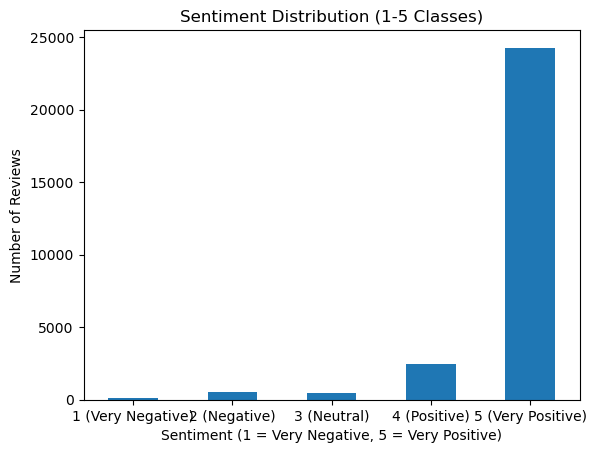

In [30]:
# Plot sentiment distribution for 5 classes
data_clean['sentiment'].value_counts().sort_index().plot(kind='bar')
plt.title('Sentiment Distribution (1-5 Classes)')
plt.xlabel('Sentiment (1 = Very Negative, 5 = Very Positive)')
plt.xticks(range(5), ['1 (Very Negative)', '2 (Negative)', '3 (Neutral)', '4 (Positive)', '5 (Very Positive)'], rotation=0)
plt.ylabel('Number of Reviews')
plt.show()

### Compare the given rating with the model 

   reviews.rating  sentiment  rating_sentiment_match
0             5.0          5                    True
1             5.0          5                    True
2             5.0          4                   False
3             4.0          5                   False
4             5.0          5                    True
Accuracy of VADER sentiment compared to ratings: 64.48%


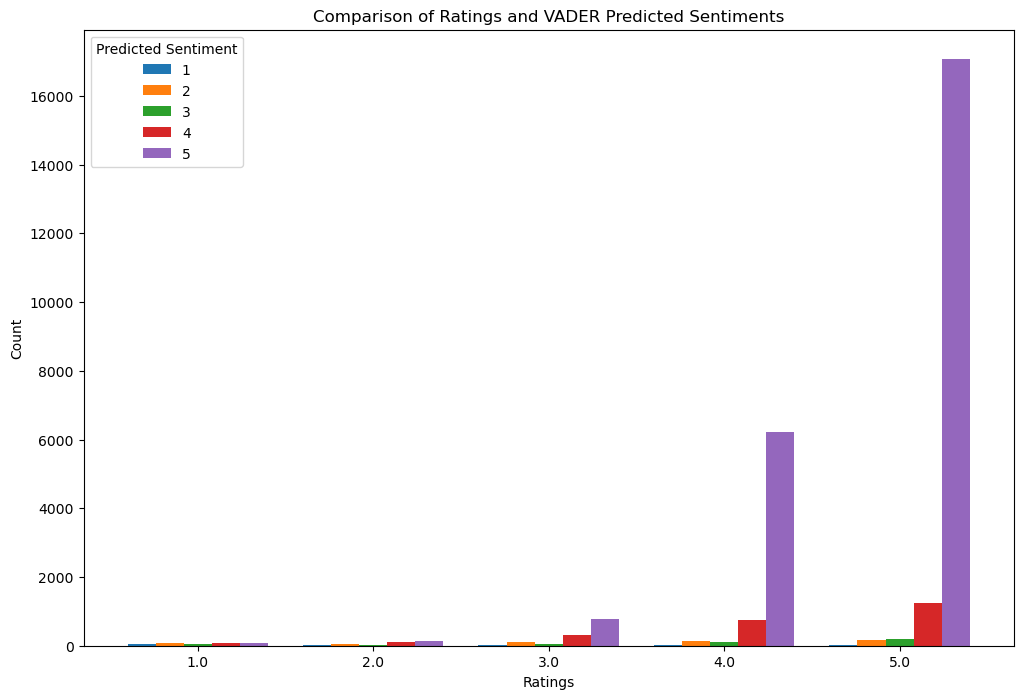

In [31]:
# Step 1: Create a comparison column
# Match if the VADER sentiment (1-5) equals the rating (1-5)
data_clean['rating_sentiment_match'] = data_clean['reviews.rating'] == data_clean['sentiment']

# Preview the dataset
print(data_clean[['reviews.rating', 'sentiment', 'rating_sentiment_match']].head())

# Step 2: Calculate Accuracy
accuracy = data_clean['rating_sentiment_match'].mean() * 100
print(f"Accuracy of VADER sentiment compared to ratings: {accuracy:.2f}%")

# Step 1: Prepare Data for Comparison
comparison_data = data_clean.groupby(['reviews.rating', 'sentiment']).size().unstack(fill_value=0)

# Step 2: Plot Side-by-Side Bars
comparison_data.plot(kind='bar', figsize=(12, 8), width=0.8)

# Step 3: Customize the Plot
plt.title("Comparison of Ratings and VADER Predicted Sentiments")
plt.xlabel("Ratings")
plt.ylabel("Count")
plt.xticks(rotation=0)
plt.legend(title="Predicted Sentiment", loc='upper left')
plt.show()

In [32]:
# Filter for mismatches where rating is not equal to sentiment
mismatches = data_clean[data_clean['reviews.rating'] != data_clean['sentiment']]

# Display the mismatched rows
print("Mismatched Rows:")
print(mismatches[['reviews.rating', 'sentiment', 'cleaned_text']])

# # Save the mismatches to a CSV file for further analysis (optional)
# mismatches.to_csv('mismatches.csv', index=False)

Mismatched Rows:
       reviews.rating  sentiment  \
2                 5.0          4   
3                 4.0          5   
6                 4.0          5   
10                4.0          5   
12                4.0          5   
...               ...        ...   
27889             4.0          5   
27891             3.0          5   
27894             3.0          5   
27897             4.0          5   
27898             3.0          5   

                                            cleaned_text  
2      beginner tablet year old son inexpensive table...  
3      good ive fire hd two weeks love tablet great v...  
6      great ereader tablet great ereading go nice li...  
10     nice tablet price easy elderly users cease ads...  
12     great value wanted father first tablet good va...  
...                                                  ...  
27889  alexa good quickly finding music alexa good qu...  
27891  good speaker good speaker limited dont big mus...  
27894  great buy la

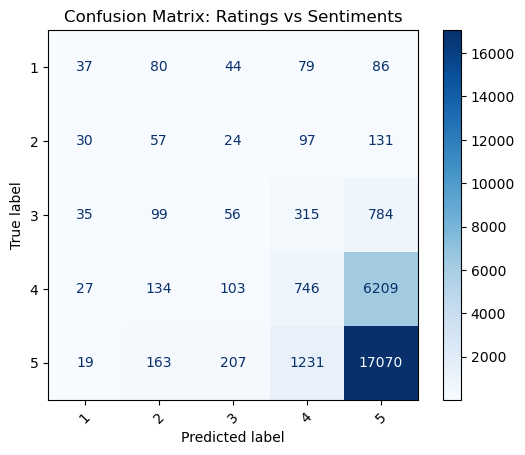

In [33]:
# Generate confusion matrix
cm = confusion_matrix(data_clean['reviews.rating'], data_clean['sentiment'])

# Display confusion matrix
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=[1, 2, 3, 4, 5])
disp.plot(cmap='Blues', xticks_rotation=45)
plt.title('Confusion Matrix: Ratings vs Sentiments')
plt.show()

In [34]:
# Generate classification report
print("Classification Report:")
print(classification_report(data_clean['reviews.rating'], data_clean['sentiment'], target_names=["1", "2", "3", "4", "5"]))

Classification Report:
              precision    recall  f1-score   support

           1       0.25      0.11      0.16       326
           2       0.11      0.17      0.13       339
           3       0.13      0.04      0.07      1289
           4       0.30      0.10      0.15      7219
           5       0.70      0.91      0.79     18690

    accuracy                           0.64     27863
   macro avg       0.30      0.27      0.26     27863
weighted avg       0.56      0.64      0.58     27863



# Part II: Clustering Categories

### Creating Clusters

In [35]:
# Combine 'name' and 'categories' into a single column
data_clean['name_and_category'] = data_clean['name'].str.lower() + " " + data_clean['categories']

# Preprocess categories: Lowercase and remove special characters
data_clean['categories_clean'] = data_clean['name_and_category'].str.lower().str.strip()
data_clean['categories_clean'] = data_clean['categories_clean'].str.replace('[^a-zA-Z, ]', '', regex=True)

# Combine multiple categories into one string if necessary
data_clean['categories_clean'] = data_clean['categories_clean'].str.replace(',', ' ')
print(data_clean['categories_clean'].head(27000))

0        allnew fire hd  tablet   hd display  wifi   gb...
1        allnew fire hd  tablet   hd display  wifi   gb...
2        allnew fire hd  tablet   hd display  wifi   gb...
3        allnew fire hd  tablet   hd display  wifi   gb...
4        allnew fire hd  tablet   hd display  wifi   gb...
                               ...                        
27032    amazon fire tv   amazon fire tv    stereos rem...
27033    amazon fire tv   amazon fire tv    stereos rem...
27034    amazon fire tv   amazon fire tv    stereos rem...
27035    amazon fire tv   amazon fire tv    stereos rem...
27036    amazon fire tv   amazon fire tv    stereos rem...
Name: categories_clean, Length: 27000, dtype: object


In [36]:
# Replace incorrect entries of Amazon Fire Stick and Echo in the 'name' column

# Count rows that contain "Amazon Fire Tv,,"
original_count = data_clean['name'].str.contains("Amazon Fire Tv,,", na=False).sum()

# Replace rows where 'name' contains "Amazon Fire Tv,,"
data_clean.loc[data_clean['name'].str.contains("Amazon Fire Tv,,", na=False), 'name'] = "Amazon Echo"

# Print the number of changes
print(f"Number of changes made: {original_count}")

Number of changes made: 2528


In [37]:


# Replace incorrect entries of Tablet and Kindle Voyage in the 'name' column

# Count rows that contain "Amazon Fire Hd 8 8in Tablet 16gb)"
original_count = data_clean['name'].str.contains("Amazon Fire Hd 8 8in Tablet 16gb", na=False).sum()

# Replace rows where 'name' contains "Amazon Fire Hd 8 8in Tablet 16gb Black B018szt3bk 6th Gen (2016)"
data_clean.loc[data_clean['name'].str.contains("Amazon Fire Hd 8 8in Tablet 16gb", na=False), 'name'] = "Kindle Voyage"

# Print the number of changes
print(f"Number of changes made: {original_count}")


Number of changes made: 135


In [38]:
# Remove Stopwords from category_clean

# Define custom stopwords
custom_stopwords = {'allnew', 'magenta', 'hd', 'gb', 'includes', 'special', 'offers', 'wifi', 'display', 'electronics', 
                    'ipad', 'computers', 'white', 'black', 'red', 'docks', 'mini', 'features', 'stereos', 'kitchen',
                    'dining', 'microusb', 'controls', 'clearance', 'cayenne', 'standing', 'protective', 'caseth', 'generation', 
                    'oasis', 'leather', 'merlot', 'highresolution', 'ppi', 'cover', 'store', 'glarefree',
                    'touchscreen', 'device', 'offer', 'stereo', 'feature', 'latest',  'official', 'oem', 'dx', 'fit', 'nd', 'dxs',
                    'ft', 'work', 't', 'new', 'home', 'theater', 'shop', 'hubs', 'college', 'security', 'automation', 'wireless', 'office',
                    'featured', 'brands', 'frys', 'entertainment', 'media', 'toys', 'holidays', 'streaming', 'tech', 'movies', 'music', 'android'
                    }

# Add custom stopwords
stop_words.update(custom_stopwords)

def remove_stopwords(text):
    # Split text into words, filter out stopwords, and join back into a single string
    if isinstance(text, str):  # Ensure the input is a string
        words = text.split()
        filtered_words = [word for word in words if word.lower() not in stop_words]
        return " ".join(filtered_words)
    return text  # Return text unchanged if it's not a string

# Remove stopwords from the 'name_and_category' column
data_clean['categories_clean'] = data_clean['categories_clean'].apply(remove_stopwords)

# Preview the cleaned column
print(data_clean['categories_clean'].head())

0    fire tablet tablets tablets fire tablets table...
1    fire tablet tablets tablets fire tablets table...
2    fire tablet tablets tablets fire tablets table...
3    fire tablet tablets tablets fire tablets table...
4    fire tablet tablets tablets fire tablets table...
Name: categories_clean, dtype: object


In [39]:
def add_cluster_weight(text, cluster_keywords):
    for keyword in cluster_keywords:
        if keyword in text:
            text += f" {keyword} {keyword}"  # Add weight to matching terms
    return text
cluster_keywords = ["tablet", "tv", "smart", "kindle", "eReader"]
data_clean['categories_clean'] = data_clean['categories_clean'].apply(lambda x: add_cluster_weight(x, cluster_keywords))

#### Exploring for a cluster by word cloud

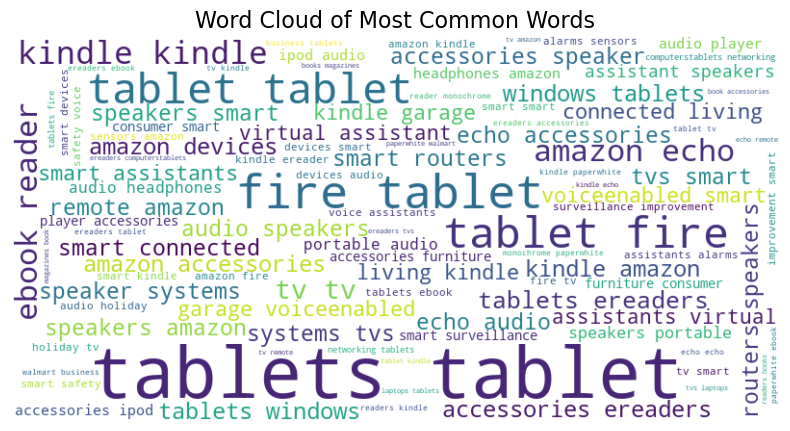

Most Common Words:
tablets: 121109
tablet: 61301
smart: 47568
kindle: 41660
fire: 39504
amazon: 37485
accessories: 27016
audio: 23784
tv: 23422
echo: 18531
ereaders: 18485
speakers: 17838
devices: 12308
ebook: 12184
assistants: 11892
tvs: 9122
readers: 9008
paperwhite: 6801
speaker: 6582
portable: 6582


In [40]:
# Combine all text data from the 'categories_clean' column
text = " ".join(data_clean['categories_clean'].astype(str).tolist())

# Generate the word cloud
wordcloud = WordCloud(
    width=800, 
    height=400, 
    background_color='white', 
    max_words=100,  # Number of most common words to show
    colormap='viridis'
).generate(text)

# Plot the word cloud
plt.figure(figsize=(10, 5))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")  # Turn off axis labels
plt.title("Word Cloud of Most Common Words", fontsize=16)
plt.show()

# Combine all text data from the 'categories_clean' column
text = " ".join(data_clean['categories_clean'].astype(str).tolist())

# Count the most common words
word_counts = Counter(text.split())
most_common_words = word_counts.most_common(20)  # Top 20 words

# Convert to a list of dictionaries for better readability
most_common_words_list = [{"word": word, "count": count} for word, count in most_common_words]

# Print the list
print("Most Common Words:")
for item in most_common_words_list:
    print(f"{item['word']}: {item['count']}")

In [41]:
# Step 1: Load a lightweight pre-trained model
model = SentenceTransformer('all-MiniLM-L6-v2')  # Lightweight and efficient

# Step 2: Generate embeddings for categories_clean
category_embeddings = model.encode(data_clean['categories_clean'].tolist())

# Step 3: Generate embeddings for predefined cluster names
cluster_labels = ["Tablets", "TV", "Smart Home", "eReader", "Others"]
cluster_label_embeddings = model.encode(cluster_labels)

# Step 4: Apply K-Means Clustering
n_clusters = len(cluster_labels)  # Number of predefined clusters
# kmeans = KMeans(n_clusters=n_clusters, random_state=42)
kmeans = KMeans(n_clusters=n_clusters, init=cluster_label_embeddings, random_state=42)
data_clean['category_cluster'] = kmeans.fit_predict(category_embeddings)

# Step 5: Match Clusters to Predefined Names
centroids = kmeans.cluster_centers_
cluster_mapping = {}
for i, centroid in enumerate(centroids):
    similarities = cosine_similarity([centroid], cluster_label_embeddings)[0]
    best_match = np.argmax(similarities)
    cluster_mapping[i] = cluster_labels[best_match]

# Step 6: Assign Cluster Names
data_clean['cluster_name'] = data_clean['category_cluster'].map(cluster_mapping)

# Step 7: Inspect Results
print(data_clean[['categories_clean', 'category_cluster', 'cluster_name']].head(10))

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


                                    categories_clean  category_cluster  \
0  fire tablet tablets tablets fire tablets table...                 0   
1  fire tablet tablets tablets fire tablets table...                 0   
2  fire tablet tablets tablets fire tablets table...                 0   
3  fire tablet tablets tablets fire tablets table...                 0   
4  fire tablet tablets tablets fire tablets table...                 0   
5  fire tablet tablets tablets fire tablets table...                 0   
6  fire tablet tablets tablets fire tablets table...                 0   
7  fire tablet tablets tablets fire tablets table...                 0   
8  fire tablet tablets tablets fire tablets table...                 0   
9  fire tablet tablets tablets fire tablets table...                 0   

  cluster_name  
0      Tablets  
1      Tablets  
2      Tablets  
3      Tablets  
4      Tablets  
5      Tablets  
6      Tablets  
7      Tablets  
8      Tablets  
9      Tablets 

In [42]:
data_clean.columns

Index(['name', 'brand', 'categories', 'reviews.date', 'reviews.numHelpful',
       'reviews.rating', 'reviews.text', 'reviews.title', 'combined_text',
       'cleaned_text', 'tokenized_text', 'sentiment', 'rating_sentiment_match',
       'name_and_category', 'categories_clean', 'category_cluster',
       'cluster_name'],
      dtype='object')

In [43]:
# Inspect categories in each cluster
for cluster in range(n_clusters):
    print(f"\nCluster {cluster}:")
    print(data_clean[data_clean['category_cluster'] == cluster]['categories_clean'].unique())


Cluster 0:
['fire tablet tablets tablets fire tablets tablets tablets tablet tablet'
 'fire tablet tablets fire tablets computer components hard drives storage tablets tablets tablet tablet'
 'fire tablet alexa tangerine tablets fire tablets computer components hard drives storage tablets tablets tablet tablet'
 'fire tablet alexa tangerine tablets fire tablets tablets tablets tablet tablet'
 'fire tablet fire tablets tablets tablets tablets tablets tablets tablet tablet'
 'fire tablet alexa tangerine fire tablets tablets tablets tablets tablets tablets tablet tablet'
 'amazon case fire th amazon case fire th fire tablets tablets tablets tablets tablets tablets tablet tablet'
 'certified refurbished amazon fire tv previous st certified refurbished amazon fire tv previous st fire tablets tablets tablets tablets tablets tablets tablet tablet tv tv'
 'fire kids edition tablet green kidproof case computerstablets networking tablets ebook readers tablets tablets tablets tablet tablet'
 'fi

In [44]:


# Step 1: Create the TF-IDF matrix
vectorizer = TfidfVectorizer(max_features=1000)  # Adjust features as needed
tfidf_matrix = vectorizer.fit_transform(data_clean['categories_clean'])

# Step 2: Calculate the centroids of each cluster
cluster_centroids = []
for cluster_id in sorted(data_clean['category_cluster'].unique()):
    # Get the rows corresponding to each cluster
    cluster_data = tfidf_matrix[np.where(data_clean['category_cluster'] == cluster_id)[0]]
    # Calculate the centroid of the cluster
    centroid = cluster_data.mean(axis=0)
    cluster_centroids.append(centroid)

# Convert the centroids list to a numpy array
cluster_centroids = np.array(cluster_centroids).squeeze()

# Step 3: Calculate pairwise cosine similarity between cluster centroids
similarities = cosine_similarity(cluster_centroids)

# Step 4: Print the similarity scores between clusters
for i in range(len(similarities)):
    for j in range(len(similarities)):
        if i != j:  # Skip self-similarity
            print(f"Similarity between Cluster {i} and {j}: {similarities[i, j]:.2f}")

Similarity between Cluster 0 and 1: 0.01
Similarity between Cluster 0 and 2: 0.02
Similarity between Cluster 0 and 3: 0.37
Similarity between Cluster 0 and 4: 0.54
Similarity between Cluster 1 and 0: 0.01
Similarity between Cluster 1 and 2: 0.09
Similarity between Cluster 1 and 3: 0.00
Similarity between Cluster 1 and 4: 0.00
Similarity between Cluster 2 and 0: 0.02
Similarity between Cluster 2 and 1: 0.09
Similarity between Cluster 2 and 3: 0.18
Similarity between Cluster 2 and 4: 0.14
Similarity between Cluster 3 and 0: 0.37
Similarity between Cluster 3 and 1: 0.00
Similarity between Cluster 3 and 2: 0.18
Similarity between Cluster 3 and 4: 0.53
Similarity between Cluster 4 and 0: 0.54
Similarity between Cluster 4 and 1: 0.00
Similarity between Cluster 4 and 2: 0.14
Similarity between Cluster 4 and 3: 0.53


In [45]:
# Reassign “Unknown” Entries 

# data_clean['cluster_name'] = data_clean['cluster_name'].replace("unknown", "Others")

In [46]:
# Function to fix specific misclassifications
def fix_specific_classifications(row):
    description = row['categories_clean'].lower()  # Convert to lowercase for consistency

    # Prioritized conditions to avoid overlaps
    if "fire tablet" in description or "fire kids" in description and not ("kindle fits" in description or "adapter charger" in description or "usb charger" in description):
        # Classify as "Tablet"
        row['category_cluster'] = 0
        row['cluster_name'] = "Tablet"
    if "echo" in description:
        # Classify as "Smart Home"
        row['category_cluster'] = 2
        row['cluster_name'] = "Smart Home"
    if "kindle" in description and ("ebook" in description or "voyage" in description or "amazon kindle" in description) and not ("kindle fits" in description or "adapter charger" in description or "usb cable" in description) or "Amazon Kindle Paperwhite - eBook reader - 4 GB" in description:
        # Classify as "eReader"
        row['category_cluster'] = 3
        row['cluster_name'] = "eReader"
    if "Amazon Kindle Paperwhite - eBook reader - 4 GB - 6 monochrome Paperwhite - touchscreen - Wi-Fi - black,,," in row['name'].lower():
        # Classify as "eReader"
        row['category_cluster'] = 3
        row['cluster_name'] = "eReader"

    if "kindle" in description and ("kindle fits" in description or "adapter charger" in description or "usb cable" in description) or "usb charger power adapter" in description:
        # Classify as "Other"
        row['category_cluster'] = 4
        row['cluster_name'] = "Other"

    return row

# Apply the function to the DataFrame
data_clean = data_clean.apply(fix_specific_classifications, axis=1)

In [47]:
print(data_clean.columns)

Index(['name', 'brand', 'categories', 'reviews.date', 'reviews.numHelpful',
       'reviews.rating', 'reviews.text', 'reviews.title', 'combined_text',
       'cleaned_text', 'tokenized_text', 'sentiment', 'rating_sentiment_match',
       'name_and_category', 'categories_clean', 'category_cluster',
       'cluster_name'],
      dtype='object')


In [48]:

# Define the mapping of category_cluster to cluster names
cluster_name_mapping = {
    0: "Tablet",
    1: "TV",
    2: "Smart Home",
    3: "eReader",
    4: "Other"
}

# Add a new column with cluster names to the DataFrame
data_clean['cluster_name'] = data_clean['category_cluster'].map(cluster_name_mapping)

# Create a summary dictionary to store the results
cluster_summary = {}

# Iterate through the grouped data
for cluster, group in data_clean.groupby('category_cluster'):
    # Calculate cluster details
    cluster_name = cluster_name_mapping.get(cluster, "Unknown")
    count = len(group)
    top_terms = Counter(" ".join(group['categories_clean']).split()).most_common(10)
    
    # Store in the summary dictionary
    cluster_summary[cluster] = {
        "cluster_name": cluster_name,
        "count": count,
        "top_terms": top_terms
    }

# Print the cluster summary
for cluster, summary in cluster_summary.items():
    print(f"Cluster {cluster}: {summary['cluster_name']}")
    print(f"  Count: {summary['count']}")
    print(f"  Top Terms: {summary['top_terms']}")
    print("-" * 40)

Cluster 0: Tablet
  Count: 15729
  Top Terms: [('tablets', 87423), ('tablet', 47177), ('fire', 31163), ('kids', 1691), ('case', 1687), ('edition', 1685), ('green', 1685), ('kidproof', 1685), ('ebook', 521), ('readers', 521)]
----------------------------------------
Cluster 2: Smart Home
  Count: 6290
  Top Terms: [('smart', 47040), ('amazon', 30113), ('audio', 23520), ('echo', 18382), ('speakers', 17640), ('accessories', 17640), ('kindle', 17640), ('tv', 16813), ('assistants', 11760), ('devices', 11760)]
----------------------------------------
Cluster 3: eReader
  Count: 5579
  Top Terms: [('tablets', 31134), ('kindle', 22273), ('ereaders', 17999), ('tablet', 12312), ('ebook', 11261), ('accessories', 8406), ('readers', 8085), ('paperwhite', 6614), ('tv', 6455), ('windows', 6352)]
----------------------------------------
Cluster 4: Other
  Count: 265
  Top Terms: [('kindle', 1684), ('amazon', 1147), ('accessories', 946), ('power', 673), ('tablets', 542), ('smart', 528), ('fire', 521), 

In [49]:
data_clean.columns

Index(['name', 'brand', 'categories', 'reviews.date', 'reviews.numHelpful',
       'reviews.rating', 'reviews.text', 'reviews.title', 'combined_text',
       'cleaned_text', 'tokenized_text', 'sentiment', 'rating_sentiment_match',
       'name_and_category', 'categories_clean', 'category_cluster',
       'cluster_name'],
      dtype='object')

In [50]:
# Define keywords for each cluster (based on expected categories)
keywords = {
    "Tablets": ["tablet"],
    "TV": ["tv", "remote", "screen", "amazon fire tv"],
    "Smart Home": ["Amazon Echo", "smart", "alexa", "voice", "assistant", "echo", "speakers"],
    "Others": ["unknown", "misc", "other", "usb charger", "cable", "powerfast"],
    "eReader": ["ereader", "kindle", "ebook"]

}

# Function to check for mismatches
def check_mismatch(row):
    cluster = row['cluster_name']
    text = row['categories_clean'].lower()
    for keyword in keywords.get(cluster, []):
        if keyword in text:
            return False  # No mismatch
    return True  # Mismatch found

# Find mismatched rows
data_clean['mismatch'] = data_clean.apply(check_mismatch, axis=1)
mismatches = data_clean[data_clean['mismatch']]

# Display mismatches
print(mismatches[['categories_clean', 'category_cluster', 'cluster_name']])

print(mismatches[['categories_clean', 'category_cluster', 'cluster_name']].sum())

                                        categories_clean  category_cluster  \
0      fire tablet tablets tablets fire tablets table...                 0   
1      fire tablet tablets tablets fire tablets table...                 0   
2      fire tablet tablets tablets fire tablets table...                 0   
3      fire tablet tablets tablets fire tablets table...                 0   
4      fire tablet tablets tablets fire tablets table...                 0   
...                                                  ...               ...   
27895  amazon kindle fire w powerfast adapter charger...                 4   
27896  amazon kindle fire w powerfast adapter charger...                 4   
27897  amazon kindle fire w powerfast adapter charger...                 4   
27898  amazon kindle fire w powerfast adapter charger...                 4   
27899  amazon kindle fire w powerfast adapter charger...                 4   

      cluster_name  
0           Tablet  
1           Tablet  


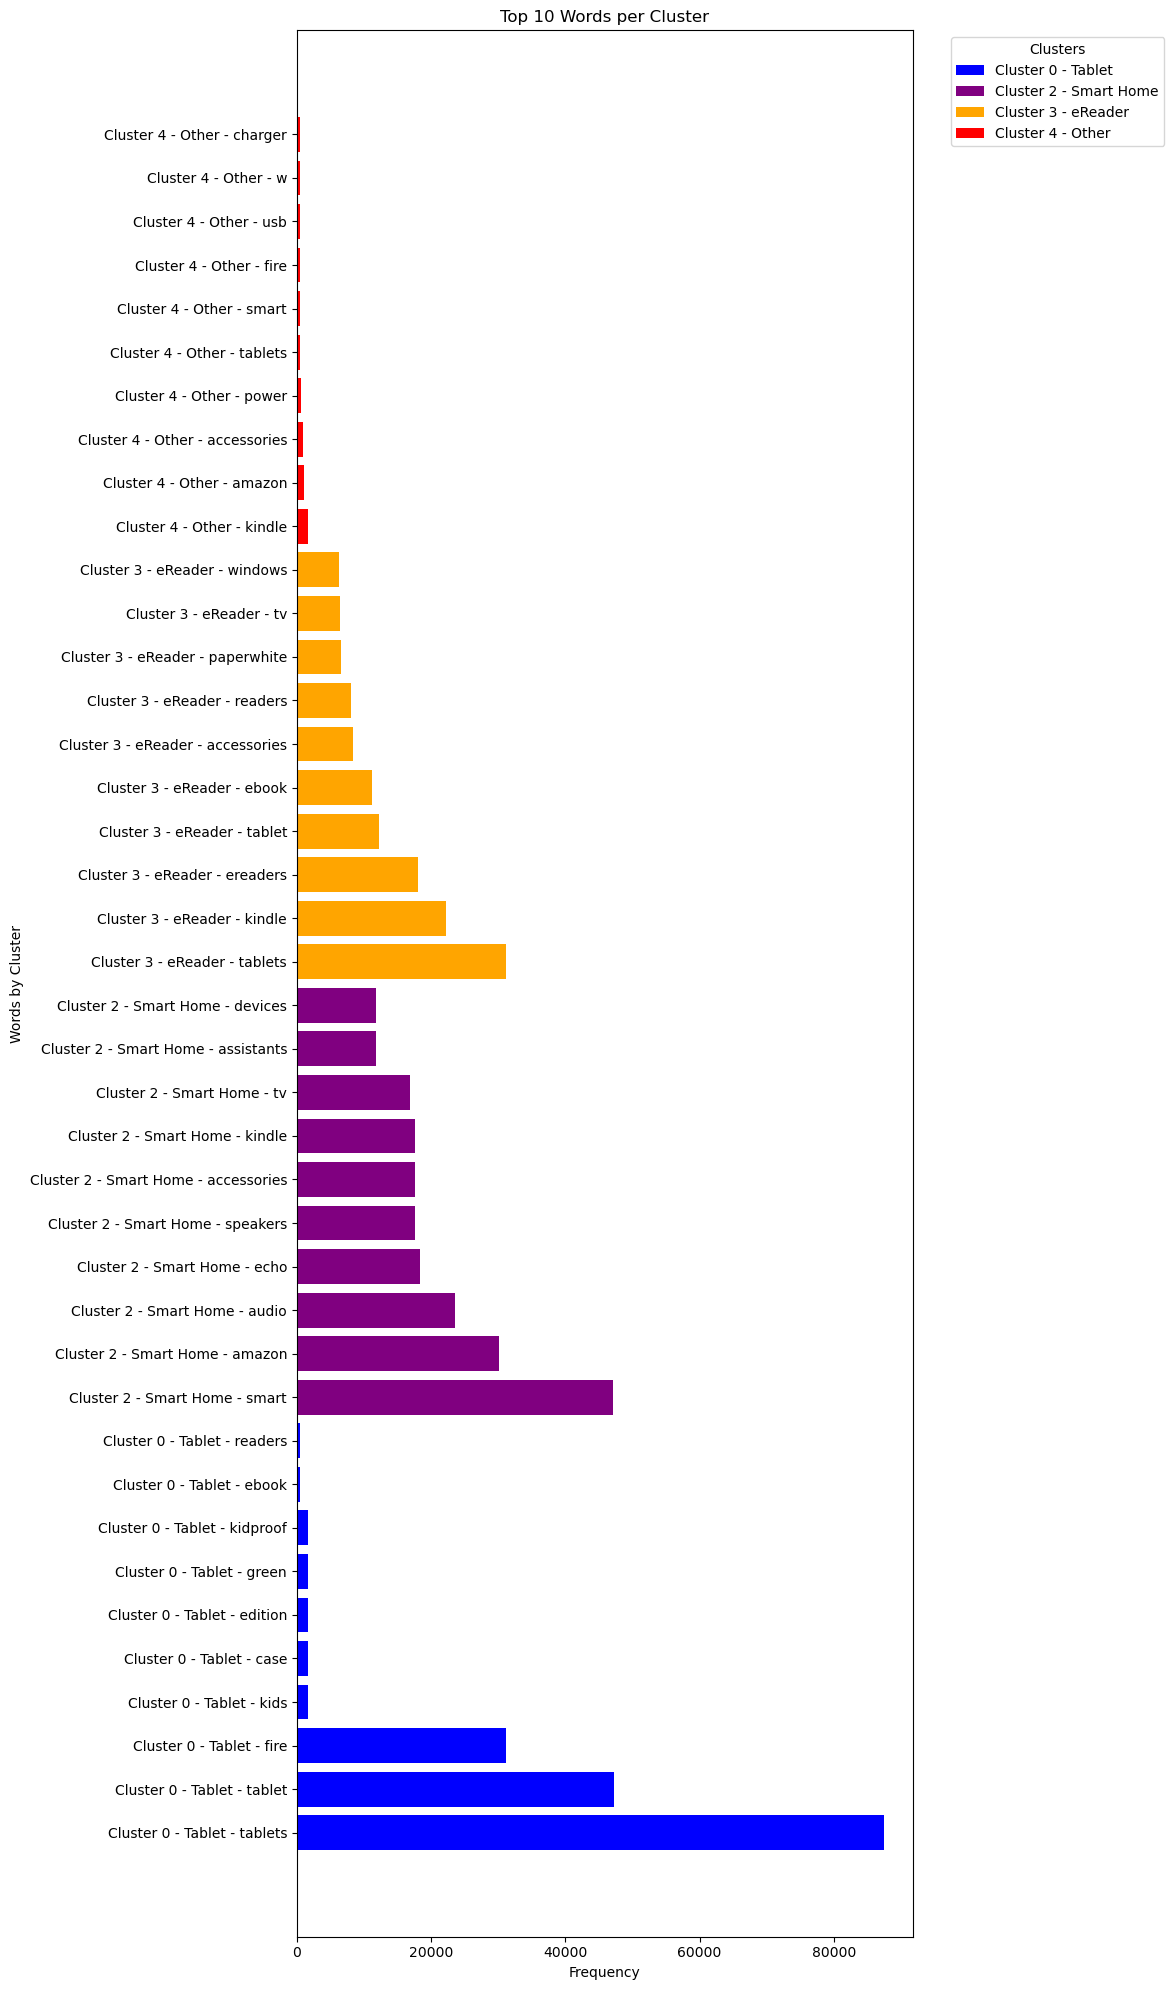

In [51]:
# Extract the top 10 words per cluster from 'categories_clean'
def get_top_words_per_cluster(data, cluster_col, text_col, top_n=10):
    cluster_top_words = {}
    for cluster in data[cluster_col].unique():
        cluster_texts = data[data[cluster_col] == cluster][text_col].str.cat(sep=' ')
        word_counts = Counter(cluster_texts.split())
        top_words = word_counts.most_common(top_n)
        cluster_top_words[cluster] = top_words
    return cluster_top_words

# Get top 10 words for each cluster
top_words_per_cluster = get_top_words_per_cluster(
    data_clean, 'category_cluster', 'categories_clean', top_n=10
)

# Prepare data for plotting
cluster_labels = {0: "Tablet", 1: "TV", 2: "Smart Home", 3: "eReader", 4: "Other"}  # Update labels if needed
plot_data = []
for cluster, words in top_words_per_cluster.items():
    for word, freq in words:
        plot_data.append({
            'Cluster': cluster,
            'Cluster Name': f"Cluster {cluster} - {cluster_labels.get(cluster, 'Unknown')}",
            'Word': word,
            'Frequency': freq
})

plot_df = pd.DataFrame(plot_data)

# Sort data by cluster and frequency for grouped plotting
plot_df.sort_values(by=['Cluster', 'Frequency'], ascending=[True, False], inplace=True)

# Define consistent colors for clusters
cluster_colors = {
    0: "blue",
    1: "green",
    2: "purple",
    3: "orange",
    4: "red"
}

# Create horizontal bar plot
plt.figure(figsize=(12, 20))

# Create y-ticks for the words grouped by cluster
y_positions = []
y_labels = []
y_start = 0

for cluster in plot_df['Cluster'].unique():
    cluster_data = plot_df[plot_df['Cluster'] == cluster]
    words = cluster_data['Word'].tolist()
    frequencies = cluster_data['Frequency'].tolist()

    y_positions.extend(range(y_start, y_start + len(words)))
    y_labels.extend([f"{cluster_data.iloc[0]['Cluster Name']} - {word}" for word in words])
    y_start += len(words)

    # Plot the bars for this cluster
    plt.barh(
        y_positions[-len(words):],  # Add only the positions for this cluster
        frequencies,
        color=cluster_colors.get(cluster, 'gray'),
        label=f"Cluster {cluster} - {cluster_labels.get(cluster, 'Unknown')}"
    )

# Set y-axis labels
plt.yticks(y_positions, y_labels)
plt.title("Top 10 Words per Cluster")
plt.xlabel("Frequency")
plt.ylabel("Words by Cluster")
plt.legend(title="Clusters", bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()

In [52]:
# Select specific columns to inspect
columns_to_save = ['name', 'categories_clean', 'category_cluster', 'cluster_name']

# # Save only the selected columns to a new CSV file
# data_clean[columns_to_save].to_csv("filtered_data_cluster.csv", index=False)

# Save only the selected columns to a new CSV file
data_clean.to_csv("dataset_with_ sentiment_clustered.csv", index=False)

# # Print confirmation message
# print("Filtered data saved to 'filtered_data_cluster.csv'")